In [1]:
%load_ext autoreload
%autoreload 2

# Necessary for M1 Mac
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import sys
sys.path.insert(0, '../src/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import tensorflow as tf
import PIL
from IPython.display import HTML
import tqdm.notebook

from dip.models import hour_glass, get_dip_model, get_dd_model
from dip.utils import read_img, gauss_noise, psnr
from dip.trainer import train
from dip.vis import plot_training

LOG = 50
NITER = 10000
K = 64

/Users/cem/venv/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0-rc0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


DIP #Params: 776579
DD #Params: 25536


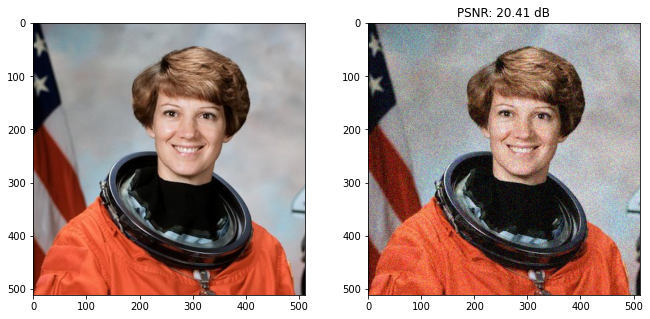

In [4]:
img = read_img('../imgs/astronaut.png')
img_n, mask = gauss_noise(img, 0.1)

dip_model = get_dip_model(img_n.shape, mask, optimizer=tf.optimizers.Adam())
dd_model = get_dd_model((8, 8, K), mask, K, optimizer=tf.optimizers.Adam())

print(f"DIP #Params: {dip_model.count_params()}")
print(f"DD #Params: {dd_model.count_params()}")

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(img)
axs[1].imshow(img_n)
axs[1].set_title(f"PSNR: {round(psnr(img, img_n), 2)} dB");

In [5]:
dip_history = train(dip_model, NITER, img_n, img, log=LOG, tqdm=tqdm.notebook)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/cem/venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [6]:
dd_history = train(dd_model, NITER, img_n, img, log=LOG, tqdm=tqdm.notebook)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

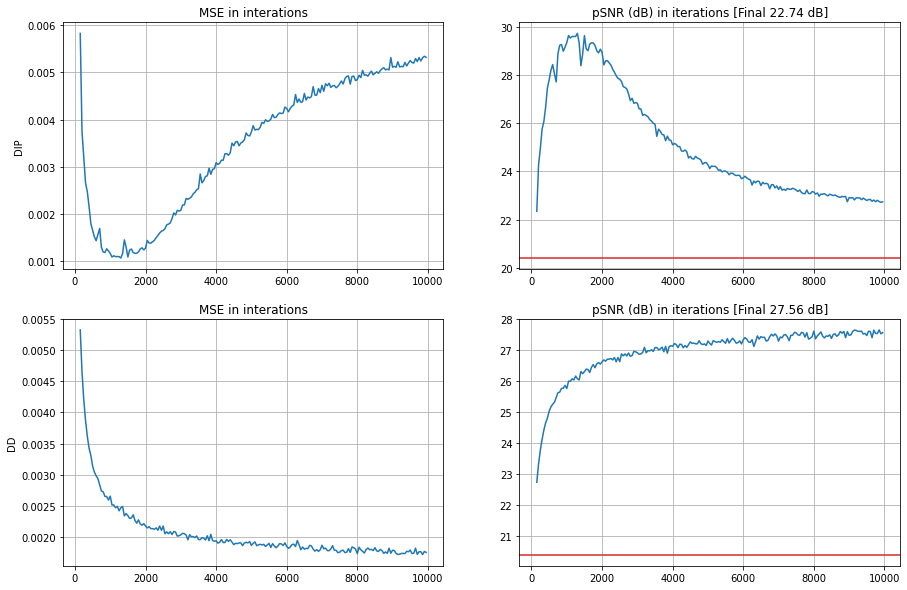

In [7]:
plot_training([dip_history, dd_history], LOG, img, img_n, plot_psnr=True, names=['DIP', 'DD']);

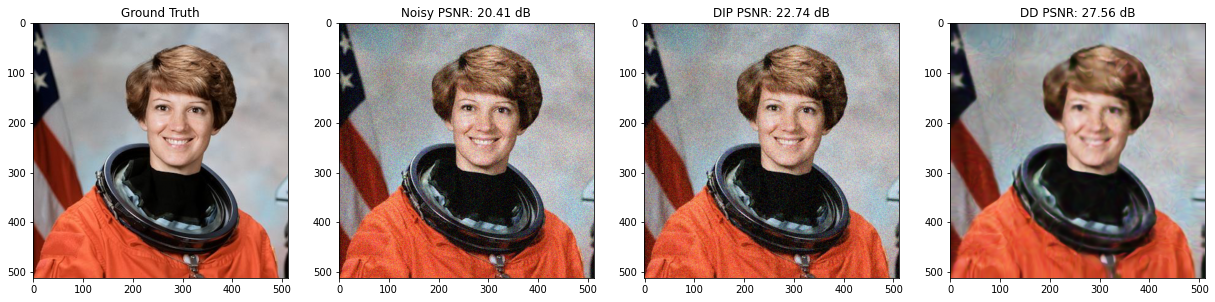

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(21, 5))
axs[0].imshow(img)
axs[0].set_title('Ground Truth')
axs[1].imshow(img_n)
axs[1].set_title(f'Noisy PSNR: {round(psnr(img, img_n), 2)} dB')
axs[2].imshow(dip_history[-1][-1])
axs[2].set_title(f"DIP PSNR: {round(psnr(img, dip_history[-1][-1]), 2)} dB");
axs[3].imshow(dd_history[-1][-1])
axs[3].set_title(f"DD PSNR: {round(psnr(img, dd_history[-1][-1]), 2)} dB");

In [9]:
n_frames = len(dd_history[0])
n_sec = 8
fps = n_frames / n_sec

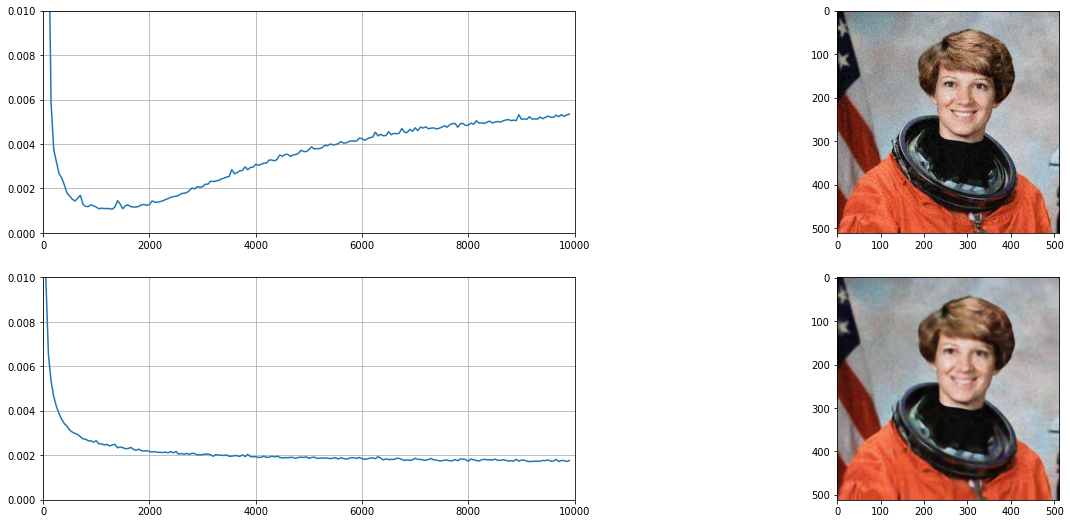

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(21, 9))
im1 = axs[0, 1].imshow(dip_history[1][0])
im2 = axs[1, 1].imshow(dd_history[1][0])

ln1 = axs[0, 0].plot([], [])[0]
ln2 = axs[1, 0].plot([], [])[0]

axs[0, 0].set_xlim(-10, NITER+10)
axs[0, 0].set_ylim(0, 0.01)
axs[0, 0].grid()

axs[1, 0].set_xlim(-10, NITER+10)
axs[1, 0].set_ylim(0, 0.01)
axs[1, 0].grid()

iter_nums = np.arange(n_frames) * LOG

def init():
    im1.set_data(dip_history[1][0])
    im1.set_data(dd_history[1][0])
    ln1.set_data([], [])
    ln2.set_data([], [])
    return [ln1, ln2, im1, im2]

def animate(i):
    im1.set_array(dip_history[1][i])
    im2.set_array(dd_history[1][i])
    
    ln1.set_data(iter_nums[:i], dip_history[0][:i])
    ln2.set_data(iter_nums[:i], dd_history[0][:i])
    return [ln1, ln2, im1, im2]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frames, interval=1/fps, blit=True)
anim.save('dip_vs_dd.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])